# Imports

In [44]:
import importlib
import functions as f  # Our defined functions
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

importlib.reload(f)

GRatio = (1 + 5 ** (1/2)) / 2

WIDTH = .5
DASH = (10, 10)


# Solving models

Model verified.
Writing new model to file models/SIS.json.
File name already exists.


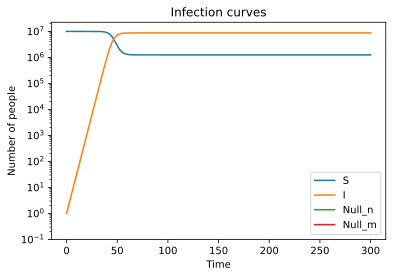

Pop variation: +0
Auto: True, Scaled: True
R0: {'Rt(S,I)': 7.261991824710811}
Auto: True, Scaled: False
R0: {'Rt(S,I)': 7.261991825180653}
Auto: False, Scaled: True
R0: {'Rt(S,I)': 7.261991424711092}
Auto: False, Scaled: False
R0: {'Rt(S,I)': 7.261991665180786}


In [45]:
name = 'SIS'
model = f.loadModel(name)
solution, t_span = f.solve(model, (0, 300), 100)

fig = plt.figure()
f.plotCurves(t_span,
             np.transpose(solution),
             toPlot=list(range(solution.shape[1])),
             labels=f.getCompartments(model))
plt.yscale('log')
plt.ylim(bottom=.1)
plt.show()

print(f"Pop variation: {f.getPopChange(model, solution):+.0f}")

for auto in [True, False]:
    for scaled in [True, False]:
        model, modelMod, _, r0 = f.computeR0(
            name, (0, 300), printInit=False, printWarnings=False,
            autoInfections=auto, scaledInfs=scaled, printText=False)
        # f.printModel(modelMod['flows']['contacts'])
        print(f'Auto: {auto}, Scaled: {scaled}')
        print(f'R0: {r0}')


Model verified.
Writing new model to file models/SIR_vars.json.
File name already exists.


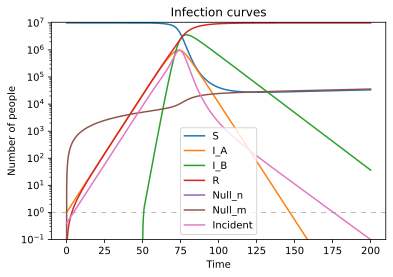

Pop variation: -15857

Creating new model!
New model created in 0.0e+00 seconds.

{'Rt(S,I_A)': 1.9979958814558698, 'Rt(S,I_B)': 0.0}


In [46]:
modelName = 'SIR_vars'

model = f.loadModel(modelName)
solution, t_span = f.solve(model, (0, 200), 100)

# SIRS_deaths2 = f.mod(SIRS_deaths)
# solution2, t_span2 = f.solve(SIRS_deaths2, (0, 200), 100)

fig = plt.figure()
f.plotCurves(t_span,
             np.transpose(solution),
             toPlot=list(range(solution.shape[1])),
             labels=f.getCompartments(model))
plt.plot(t_span, f.infCurve(model, solution, t_span), label='Incident')
plt.ylim(bottom=.1)
plt.legend(loc='best')
plt.axhline(y=1, linestyle='--', color='grey', linewidth=WIDTH, dashes=DASH)
plt.yscale('log')
plt.show()

popChange = f.getPopChange(model, solution)
print(f"Pop variation: {popChange:.0f}")

# for auto in [True, False]:
#     for scaled in [True, False]:
#         model, modelMod, _, r0 = f.computeR0(
#             modelName, printInit=False, printWarnings=False,
#             autoInfections=auto, scaledInfs=scaled)
#         # f.printModel(modelMod['flows']['contacts'])
#         print(f'Auto: {auto}, Scaled: {scaled}')
#         print(f'R0: {r0}')

f.mod(model)

model, modelMod, _, r0 = f.computeR0(
            modelName, (0, 300), printInit=False, printWarnings=False,
            autoInfections=auto, scaledInfs=scaled, printText=False)

print(r0)


Scaled: False, Auto: True
Time difference: 13.509999999999998



Scaled: False, Auto: False
Time difference: 1.509999999999998


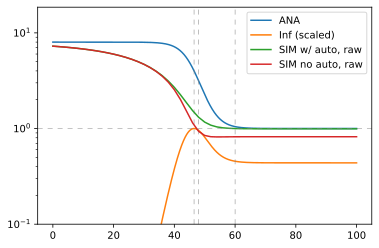

In [47]:
modelName = 'SIS'

fig = plt.figure()
plt.yscale('log')

i = 0
rtCurves = {i: None for i in range(4)}
plotedInfsLine = False

for auto in [True, False]:
    for scaled in [True, False]:
        model, newModel, solution, t_span, values = f.computeRt(
            modelName, (0, 100), sub_rt=1/2, autoInfections=auto,
            scaledInfs=scaled, write=False, printText=False)

        # if auto and scaled:
        #     fig = plt.figure()
        #     f.plotCurves(t_span,
        #                  np.transpose(solution),
        #                  toPlot=list(range(solution.shape[1])),
        #                  labels=f.getCompartments(model),
        #                  title=f'Auto: {auto}, Scaled: {scaled}')
        #     plt.ylim(bottom=.1)
        #     plt.yscale('log')
        #     plt.axhline(y=1, linestyle='--', color='grey',
        #                 linewidth=WIDTH, dashes=DASH)
        #     plt.show()

        if scaled and auto:
            infsScaled = f.infCurveScaled(model, solution, t_span)
            rt_ANA = 8 * solution[:, 0] / \
                np.array([f.popTot(model, x) for x in solution])
            rt_times = np.array([key for key in values])
            plt.plot(t_span, rt_ANA, label='ANA')
            plt.plot(t_span, infsScaled, label='Inf (scaled)')

        rt = np.zeros_like(rt_times, dtype='float64')
        for rtNode in f.getRtNodes(f.mod(model, False, False)):
            rt_rtNode = np.array([values[key][rtNode] for key in values])
            # if len(f.getRtNodes(f.mod(model, False, False))) > 1:
            #     plt.plot(rt_times, rt_rtNode, label=rtNode)
            rt += rt_rtNode

        rtCurves[i] = rt

        if ((not scaled) and auto) or (not scaled and not auto):
        # if True:
            print(f'Scaled: {scaled}, Auto: {auto}')
            if f.doesIntersect(rt, 1):
                idx_infs = f.find_nearest(infsScaled, 1)
                xTimeInfs = t_span[idx_infs]
                idx_rt = f.find_intersections(rt, 1)[0]
                try:
                    xTimeRt = rt_times[idx_rt]
                except:
                    xTimeRt = (rt_times[int(idx_rt)] + rt_times[int(idx_rt + 1)]) / 2
                print(f'Time difference: {np.abs(xTimeInfs - xTimeRt)}')
                if not plotedInfsLine:
                    plt.axvline(x=xTimeInfs, linestyle='--', color='grey',
                                linewidth=WIDTH, dashes=DASH)
                    plotedInfsLine = True
                plt.axvline(x=xTimeRt, linestyle='--', color='grey',
                            linewidth=WIDTH, dashes=DASH)

                # print(f'rt time: {xTimeRt}, inf time: {xTimeInfs}')
                # print(f'rt intersections: {f.find_intersections(rt, 1)}')
            else:
                print('Time difference is not relevant, '
                    + 'no intersection between rt and 1.')

            plt.plot(rt_times, rt, label='SIM' +
                    (' w/ auto' if auto else ' no auto') +
                    (', scaled' if scaled else ', raw'))

        # popChange = f.getPopChange(model, solution)
        # print(f"Pop variation: {popChange:.0f}")

        i += 1

        # assert 1 == 0

plt.axhline(y=1, linestyle='--', color='grey',
            linewidth=WIDTH, dashes=DASH)
plt.ylim(bottom=.1)
plt.legend(loc='best')
plt.show()


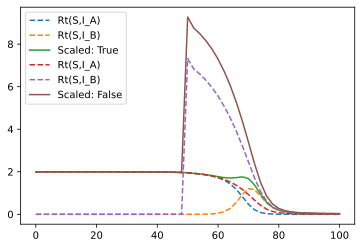

In [48]:
for scaled in [True, False]:
    model, newModel, solution, t_span, values = f.computeRt(
                'SIR_vars', (0, 100), sub_rt=1/2, autoInfections=True,
                scaledInfs=scaled, write=False, printText=False,
                printInit=False, printWarnings=False)

    rt_times = np.array([key for key in values])
    rt = np.zeros_like(rt_times, dtype='float64')
    for rtNode in f.getRtNodes(f.mod(model, False, False)):
        rt_rtNode = np.array([values[key][rtNode] for key in values])
        if len(f.getRtNodes(f.mod(model, False, False))) > 1:
            plt.plot(rt_times, rt_rtNode, label=rtNode, linestyle='--')
        rt += rt_rtNode

    plt.plot(rt_times, rt, label=f'Scaled: {scaled}')
plt.legend(loc='upper left')

In [38]:
model, newModel, solution, t_span, values = f.computeRt(
    'SIR_vars', (0, 100), sub_rt=1/2, autoInfections=True,
    scaledInfs=False, write=False, printText=False,
    printInit=False, printWarnings=False)

rt_times = np.array([key for key in values])
rt = np.zeros_like(rt_times, dtype='float64')
for rtNode in f.getRtNodes(f.mod(model, False, False)):
    rt_rtNode = np.array([values[key][rtNode] for key in values])

    idx = np.where(rt_rtNode > 0)
    if len(f.getRtNodes(f.mod(model, False, False))) > 1:
        plt.plot(rt_times[idx], rt_rtNode[idx], label=rtNode, linestyle='--')
    rt += rt_rtNode

idx = np.where(rt > 0)
plt.plot(rt_times[idx], rt[idx], label=f'Scaled: {False}')

[<function derivativeFor.<locals>.derivativeForThis at 0x000001586316DA60>, <function derivativeFor.<locals>.derivativeForThis at 0x0000015863149310>, <function derivativeFor.<locals>.derivativeForThis at 0x0000015863149F70>, <function derivativeFor.<locals>.derivativeForThis at 0x0000015863150280>, <function derivativeFor.<locals>.derivativeForThis at 0x00000158631501F0>, <function derivativeFor.<locals>.derivativeForThis at 0x0000015863150160>]


AssertionError: 

In [39]:
timesTotalPerc = np.round(100 * f.timesTotal / np.sum(f.timesTotal), 0)
print(f'Time % model_derivative: {timesTotalPerc}')

TypeError: unsupported operand type(s) for *: 'int' and 'NoneType'

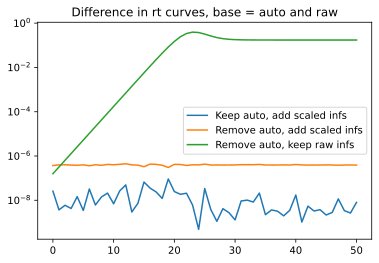

In [48]:
fig = plt.figure()

plt.title('Difference in rt curves, base = auto and raw')
plt.plot(np.abs(rtCurves[1] - rtCurves[0]), label='Keep auto, add scaled infs')
plt.plot(np.abs(rtCurves[1] - rtCurves[2]), label='Remove auto, add scaled infs')
plt.plot(np.abs(rtCurves[1] - rtCurves[3]), label='Remove auto, keep raw infs')

plt.yscale('log')
plt.legend(loc='best')
plt.show()

{
  "Rt(S,I)": 7.2552541611613375
}
Should get 8.


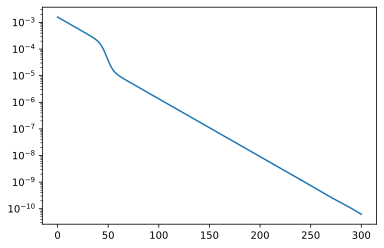

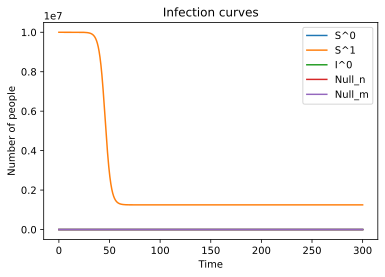

2.904796439592617 7.261991825180653


In [ ]:
SIS, SISmod, initialConds, R0 = f.computeR0(
    "SIS", write=True, overWrite=True, whereToAdd='contact',
    printInit=False, printText=False)
f.printModel(R0)
print(f'Should get 8.')

# modelOld, newModel, solutionOld, t_spanOld, values = f.computeRt(
#     'SIS', (0, 0), whereToAdd='contact', printInit=True)
# f.printModel(values)

newModel = f.mod(SIS, False, False, autoInfections=True)

init = {comp: initialConds[i] for i, comp in enumerate(f.getCompartments(SIS))}
# initialize(newModel, init, modelOld, printText=printInit, whereToAdd=whereToAdd)
f.initialize(newModel, init, 0, 0, originalModel=SIS,
             printText=False, whereToAdd='contact',
             scaled=False)

solution, t_span = f.solve(newModel, (0, 300), 100)
rts = solution[:, f.getCompartments(newModel).index('Rt(S,I)')]
s_1 = solution[:, f.getCompartments(newModel).index('S^1')]
i_0 = solution[:, f.getCompartments(newModel).index('I^0')]

plt.plot(t_span[:-1], rts[1:] - rts[:-1])
plt.yscale('log')
plt.show()

fig = plt.figure()
f.plotCurves(t_span,
             np.transpose(solution),
             toPlot=[0, 1, 2, 4, 5],
             labels=f.getCompartments(newModel))
# plt.plot(t_span, f.infCurve(newModel, solution), label='Incident')
plt.legend(loc='best')
plt.show()

print(rts[-1], rts[-1] / f.totInfs(SIS, initialConds, t_span[-1], t_span[-1]))


In [55]:
# Intégration symbolique

import sympy as sym
from sympy import exp
tInt = sym.symbols('tInt')
func = 'exp(-tInt)'

print(sym.integrate(func, (tInt, 1, 100)))

print(eval(func))


-exp(-100) + exp(-1)
exp(-tInt)
